In [ ]:
import os
import torch
import nltk
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForSeq2Seq
import matplotlib.pyplot as plt

nltk.download('punkt_tab', quiet=True)
nltk.download('punkt', quiet=True)

c:\Users\Gapba\anaconda3\envs\tf_new_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

# Загрузка и подготовка датасета

In [ ]:
TRAIN_FILE = 'final_data/train.csv'
VALID_FILE = 'final_data/validation.csv'

MODEL_NAME = "ai-forever/rugpt3small_based_on_gpt2" 
OUTPUT_DIR = "./results_rugpt3_sum"

MAX_SOURCE_LENGTH = 512
MAX_TARGET_LENGTH = 64 
MAX_CONTEXT_LENGTH = 512

BATCH_SIZE_PER_DEVICE = 2
GRADIENT_ACCUMULATION_STEPS = 8
LEARNING_RATE = 0.00001
NUM_TRAIN_EPOCHS = 40
WEIGHT_DECAY = 0.01

In [9]:
data_files = {}
data_files["train"] = TRAIN_FILE
data_files["validation"] = VALID_FILE
raw_datasets = load_dataset("csv", data_files=data_files)

print("Пример данных из train")
print(f'Новость: {raw_datasets["train"][0]["text"]}')
print(f'Суммари: {raw_datasets["train"][0]["summary"]}')

Пример данных из train
Новость: В Китае от птичьего гриппа умерли по меньшей мере 26 человек. Несмотря на то, что большинство из 127 случаев заболевания были зарегистрированы в восточных провинциях, последний погибший родом из центральной части страны. 1 мая Всемирная организация здравоохранения предупредила, что вирус H7N9 в Китае представляет серьезную опасность для здоровья людей. До сих пор нет доказательств того, что вирус может передаваться от человека к человеку, однако ученые выразили обеспокоенность темпом распространения и серьезностью заболевания.
Суммари: Государственные СМИ Китая сообщают, что по меньшей мере 26 человек уже погибли от нового штамма вируса птичьего гриппа.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

def preprocess(examples):
    input_ids_list = []
    labels_list = []
    for text, summary in zip(examples["text"], examples["summary"]):
        prompt = "Текст: " + text.strip() + " Краткое содержание:"
        tok_p = tokenizer(prompt, truncation=True, max_length=MAX_SOURCE_LENGTH, add_special_tokens=False)
        tok_s = tokenizer(summary.strip(), truncation=True, max_length=MAX_TARGET_LENGTH, add_special_tokens=False)

        input_ids = tok_p["input_ids"] + tok_s["input_ids"] + [tokenizer.eos_token_id]
        labels = [-100] * len(tok_p["input_ids"]) + tok_s["input_ids"] + [tokenizer.eos_token_id]

        input_ids_list.append(input_ids)
        labels_list.append(labels)

    return {"input_ids": input_ids_list, "labels": labels_list}

tokenized_train = raw_datasets["train"].map(preprocess, batched=True, remove_columns=raw_datasets["train"].column_names)
tokenized_val = raw_datasets["validation"].map(preprocess, batched=True, remove_columns=raw_datasets["validation"].column_names)

Map: 100%|██████████| 3227/3227 [00:06<00:00, 516.75 examples/s]


# Настройка коллатора, модели и аргументов для обучения 

In [ ]:
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    pad_to_multiple_of=8,
    label_pad_token_id=-100
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE_PER_DEVICE,
    per_device_eval_batch_size=BATCH_SIZE_PER_DEVICE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    fp16=torch.cuda.is_available(),
    logging_steps=100,
    save_strategy="epoch",
    report_to="none",
)

trainer = Trainer( 
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator
)


C:\Users\Gapba\AppData\Local\Temp\ipykernel_13784\3191735650.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


# Дообучение модели

In [11]:
train_result = trainer.train()
trainer.save_model()

Epoch,Training Loss,Validation Loss
0,2.770000,2.652903
1,2.696200,2.624443
2,2.663700,2.607104
3,2.633200,2.594144
4,2.596800,2.584388
5,2.577000,2.576930
6,2.532100,2.570873
7,2.509100,2.566514
8,2.492400,2.561326
9,2.476400,2.558922


In [12]:
log_history = trainer.state.log_history

training_losses = []
train_steps = []
eval_losses = []
eval_epochs = []

for log_entry in log_history:
    if 'loss' in log_entry and 'eval_loss' not in log_entry and 'step' in log_entry:
        training_losses.append(log_entry['loss'])
        train_steps.append(log_entry['step'])
    if 'eval_loss' in log_entry and 'epoch' in log_entry:
        eval_losses.append(log_entry['eval_loss'])
        eval_epochs.append(round(log_entry['epoch'], 2))

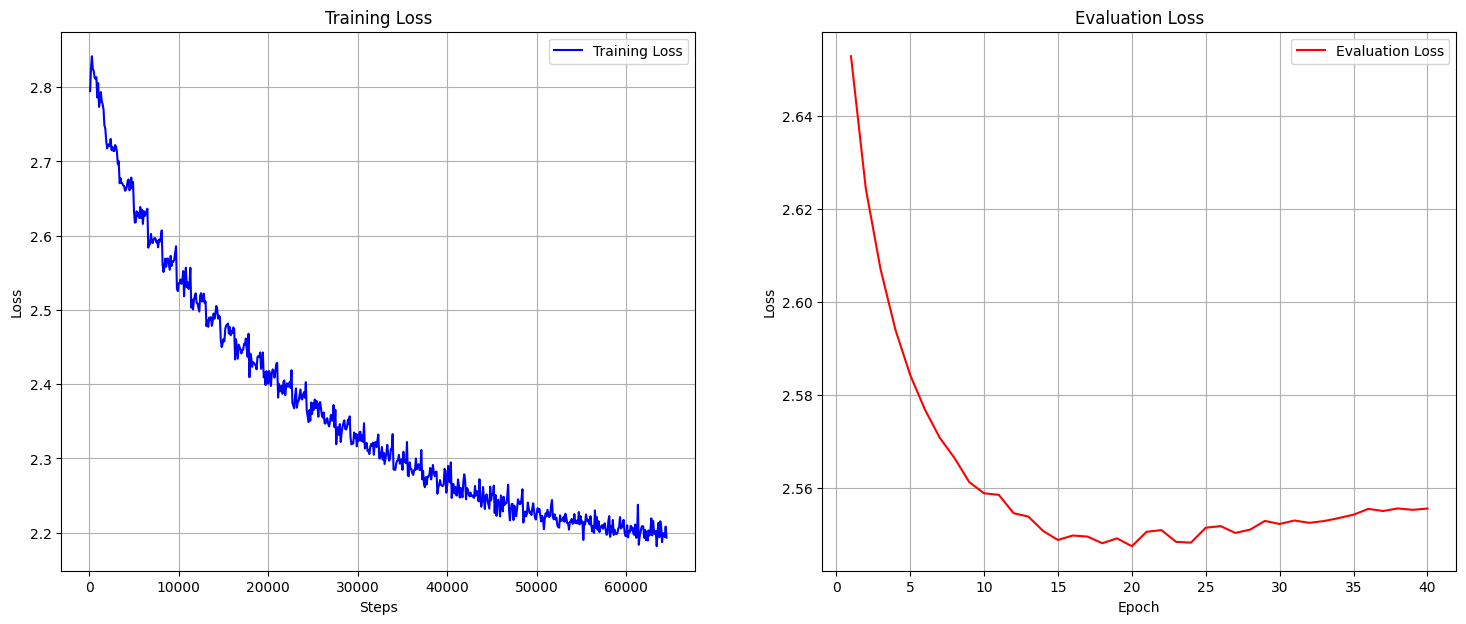

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

axes[0].plot(train_steps, training_losses, label='Training Loss', color='blue')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(eval_epochs, eval_losses, label='Evaluation Loss', color='red')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Evaluation Loss')
axes[1].legend()
axes[1].grid(True)